In [1]:
import datetime

from numpy import array
import pandas
import matplotlib.pyplot as plt

import data_pers
import useful

from model import EpidemicModel

from MCMC import TRIAL_N

from read_data import MODELLED_DAYS, MODELLED_WEEKS, POP_SIZES, T_d, T_w
from read_data import MD_LONG, MD_SHORT # mobility data
from read_data import MD_OLD_LONG, MD_OLD_SHORT  # old mobility data, for counterfactuals

In [2]:
def load_models(H, n):
    """
    Load models from the table with parameter values
    
    H: padas.DataFramw with parameter samples
    n: number of models to load. 
    prognosis: number of extra days to model.
    """
    subsample = H[::max(1, len(H)//n)]
    simulations = [EpidemicModel() for i in range(len(subsample))]
    [sim.load(row) for sim, (_, row) in zip(simulations, subsample.iterrows())]
    return simulations


def add_transformed(H):
    """
    Adds aditional columns to the pandas dataframe, 
    representing basic transformation of model parameters
    """
    N = [sim.transformed_pars() for sim in load_models(H, len(H))]
    return pandas.concat([H, pandas.DataFrame(N)], axis=1)    

In [3]:
TRIAL_N

'C:/history/covid_modelling'

# Warm-up Iterations

In [4]:
# Load warm-up iterations
H = data_pers.Load(TRIAL_N, files=[0])
print( len(H) )
print( H['Posterior'].min(), H['Posterior'].max() )

1500
-16143.866163823486 -9081.61235555405


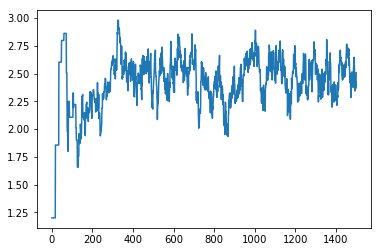

In [5]:
# show traceplots for a R_0 in Finland
plt.plot(H['Ro_fin_w'].str[0])
plt.show()

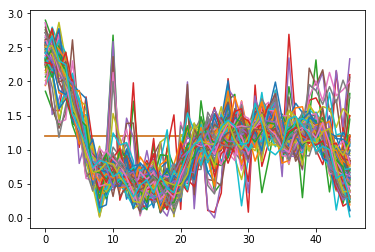

In [6]:
# show 100 samples from the whole R_t vector in Finland
S = load_models(H, n=100) 

for ep in S:
    # total number of infected
    plt.plot(ep.Ro_fin_w)
plt.show()

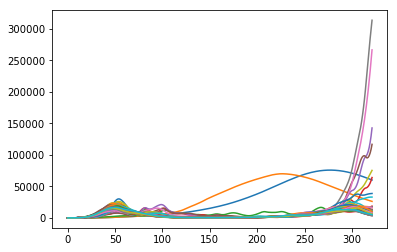

In [7]:
# show 100 epidemic trajectories (number of Infectious) in Finland
for ep in S:
    # total number of infected
    plt.plot(ep.I[0, :])
plt.show()

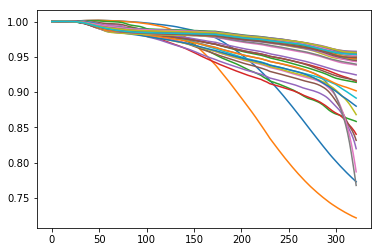

In [8]:
# show 100 epidemic trajectories (number of Susceptibles) in Finland
for ep in S:
    # total number of infected
    plt.plot(ep.S[0, :] / POP_SIZES[0])
plt.show()

# Main Iterations

In [9]:
# Load main iterations
H = data_pers.Load(TRIAL_N, files=[1])

print( len(H) )
print( H['Posterior'].min(), H['Posterior'].max() )

30000
-9144.115615165303 -9067.370281683105


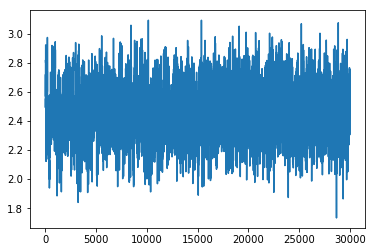

In [10]:
# show traceplots for a R_0 in Finland
plt.plot(H['Ro_fin_w'].str[0])
plt.show()

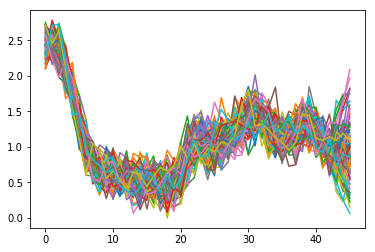

In [11]:
# show 100 samples from the whole R_t vector in Finland
S = load_models(H, n=100) 

for ep in S:
    # total number of infected
    plt.plot(ep.Ro_fin_w)
plt.show()

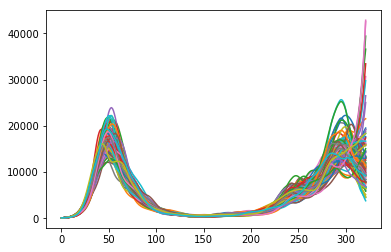

In [12]:
# show 100 epidemic trajectories (number of Infectious) in Finland
for ep in S:
    # total number of infected
    plt.plot(ep.I[0, :])
plt.show()

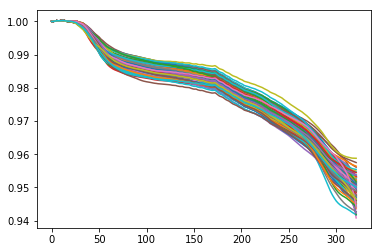

In [13]:
# show 100 epidemic trajectories (number of Susceptibles) in Finland
for ep in S:
    # total number of infected
    plt.plot(ep.S[0, :] / POP_SIZES[0])
plt.show()

# Extra Metrics

J:\covid_model_mobility_public\model.py:333: RuntimeWarning: invalid value encountered in double_scalars
  metrics['short prevalence'][x, t] =  sum(D_short_t[t, y, x] / N[y] * I[y] for y in range(4) if y != x) / sum(D_short_t[t, y, x] for y in range(4) if y != x)


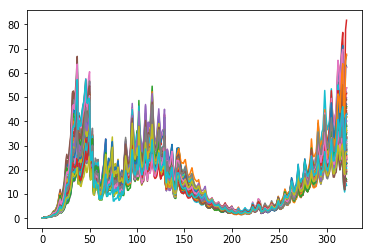

In [14]:
# Metric B
# (see equation 11)
for ep in S:
    # total number of infected
    plt.plot(ep.metrics['B'][0, :])
plt.show()

# Counterfactuals

In [15]:
n_samples = 10

In [16]:
# saving baseline scenario
S = load_models(H, n_samples)

MEAN_I = sum(epi.I for epi in S) / len(S)

In [17]:
# setting all mobility to zero
MEAN_I_CF = {}

def cut_tail(X, t):
    X[t:] *= 0
    return X

M2 = load_models(H, n_samples)
for t in range(300, 50, -1):
    if MODELLED_DAYS[t].day == 1:
        print(t, MODELLED_DAYS[t])
        for epi in M2:
            epi.do_intervention('D_long_t', cut_tail(epi.D_long_t, t))
            epi.do_intervention('D_short_t', cut_tail(epi.D_short_t, t))
            epi.do_intervention('inflow_t', cut_tail(epi.inflow_t, t))
            epi.do_intervention('M_long_out_t', cut_tail(epi.M_long_out_t, t))

        MEAN_I_CF[t] = sum(epi.I for epi in M2) / len(M2)


295 2020-12-01
265 2020-11-01
234 2020-10-01
204 2020-09-01
173 2020-08-01
142 2020-07-01
112 2020-06-01
81 2020-05-01
51 2020-04-01


In [18]:
# setting mobility to the past level
MEAN_I_CF_back = {}

def restore_tail(X, OLD_X, t):
    for i, a in enumerate(('FIN', 'SWE', 'NOR', 'DEN')):
        for j, b in enumerate(('FIN', 'SWE', 'NOR', 'DEN')):
            if a != b:
                X[t:, j, i] = OLD_X[f'{a}_2_{b}'][t:]
    return X

M2 = load_models(H, n_samples)
for t in range(300, 50, -1):
    if MODELLED_DAYS[t].day == 1:
        print(t, MODELLED_DAYS[t])
        for epi in M2:
            epi.do_intervention('D_long_t', restore_tail(epi.D_long_t, MD_OLD_LONG, t))
            epi.do_intervention('D_short_t', restore_tail(epi.D_short_t, MD_OLD_SHORT, t))

        MEAN_I_CF_back[t] = sum(epi.I for epi in M2) / len(M2) 

295 2020-12-01
265 2020-11-01
234 2020-10-01
204 2020-09-01
173 2020-08-01
142 2020-07-01
112 2020-06-01
81 2020-05-01
51 2020-04-01


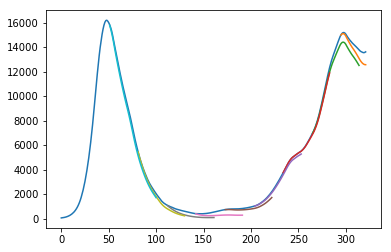

In [19]:
# Trajectory vs counterfactual trajectory
plt.plot(MEAN_I[0])
for t, mean_i in MEAN_I_CF.items():
    plt.plot(range(T_d)[t:t+50], mean_i[0, t:t+50])
plt.show()